In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# data = pd.read_csv("~/Fluid-Solutions-ML/data/processed/FINAL_TRAINING_DATA.csv")
data = pd.read_csv("https://raw.githubusercontent.com/lmitchell33/Fluid-Solutions-ML/refs/heads/main/data/processed/FINAL_TRAINING_DATA.csv")

In [51]:
# separte the data into X (input) and y (label)
X, y = data.drop(columns=['label', 'Unnamed: 0']).to_numpy(), data['label'].to_numpy()

In [52]:
# transfer the categorical data into numerical (models can only understand numerical data)
label_encoder = LabelEncoder()
y_labeled = label_encoder.fit_transform(y)

# Labels are as follows:
# high -> 0
# low -> 1
# normal -> 2

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'high': np.int64(0), 'low': np.int64(1), 'normal': np.int64(2)}

In [53]:
feature_names = data.drop(columns=['label', 'Unnamed: 0']).columns.to_list()
feature_names

['respiratory_rate',
 'heart_rate',
 'mean_arterial_pressure',
 'diastolic_arterial_pressure',
 'systolic_arterial_pressure',
 'spo2',
 'pulse_pressure']

In [ ]:
# randomly split the dat into training and testing subsets
# this is a 75/25 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_labeled, test_size=0.20, random_state=42)

In [ ]:
# create a parameter grid to perfomr the grid search with
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'max_leaf_nodes': [None, 10, 30, 50],
    'class_weight': [None, 'balanced']
}

In [56]:
# create the random forest model and perform a grid search on the param grid defined above
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10, 30, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [57]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [58]:
best_forest = grid_search.best_estimator_
best_params = grid_search.best_params_

In [59]:
y_pred = best_forest.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8389452332657201


In [60]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.01      0.01       373
         low       0.62      1.00      0.76       635
      normal       1.00      0.98      0.99      1457

    accuracy                           0.84      2465
   macro avg       0.87      0.66      0.59      2465
weighted avg       0.90      0.84      0.78      2465



In [61]:
for name, score in zip(feature_names, best_forest.feature_importances_):
  print(f"{name} -- {score}")

respiratory_rate -- 0.006599558226028111
heart_rate -- 0.01079786947349199
mean_arterial_pressure -- 0.18624147267968388
diastolic_arterial_pressure -- 0.2549689312315408
systolic_arterial_pressure -- 0.2782190828455315
spo2 -- 0.0043481843476151395
pulse_pressure -- 0.2588249011961087


In [62]:
import joblib
joblib.dump(best_forest, "/content/random_forest_model.pkl")

['/content/random_forest_model.pkl']

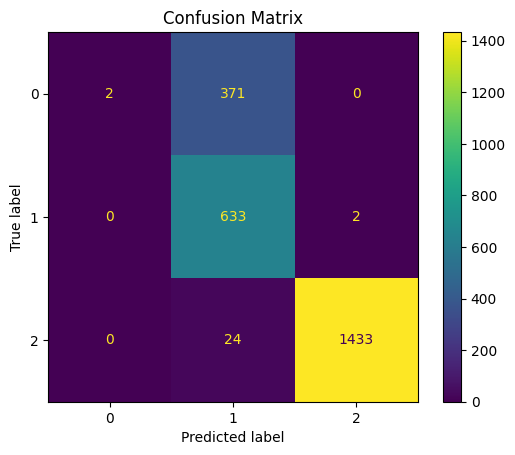

In [63]:
# create a confusion matrix to see how well the model distinguishes between classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Labels are as follows:
# high -> 0
# low -> 1
# normal -> 2

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

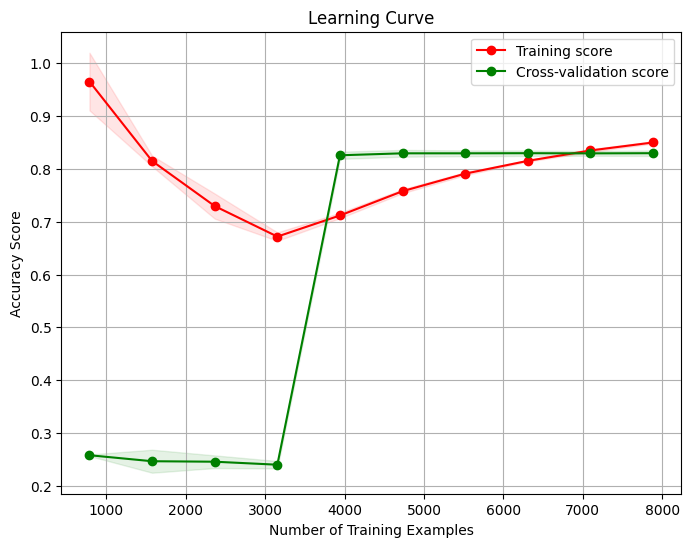

In [64]:
# Check to see how the model is fitting to the data by plotting the learning curve
from sklearn.model_selection import learning_curve
import numpy as np

best_model = RandomForestClassifier(**best_params, random_state=42)

train_sizes, train_scores, cv_scores = learning_curve(
    best_model, X, y_labeled, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)
cv_scores_std = np.std(cv_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, cv_scores_mean - cv_scores_std,
                 cv_scores_mean + cv_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, cv_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [65]:
# TODO: plot the validation curve so I can see how much each hyperparameter effects the model